### Multi-Armed Bandit problem

Multi-Armed Bandit problem can definitely address some real-world problems: Casino, Psychology: how does punishment and reward affect our behaviour? How do humans learn?, Ecology: animals have a finite amount of energy to expend, and following certain behaviours has uncertain rewards. How does the animal maximize its fitness? etc..

Any proposed strategy is called an online algorithm (in the sense that it is continuously being updated), and more specifically a reinforcement learning algorithm. The algorithm starts in an ignorant state, where it knows nothing, and begins to acquire data by testing the system. As it acquires data and results, it learns what the best and worst behaviours are (in this case, it learns which bandit is the best). With this in mind, perhaps we can add an additional application of the Multi-Armed Bandit problem:

The Bayesian solution begins by assuming priors on the probability of winning for each bandit. Let's assume complete ignorance of these probabilities. So a very natural prior is the flat prior over 0 to 1. The algorithm proceeds as follows:

For each round:

- Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
- Select the bandit with largest sample, i.e. select $B = \text{argmax}\;\; X_b$.
- Observe the result of pulling bandit $B$, and update your prior on bandit $B$.
- Return to 1.

The algorithm suggests that we should not discard losers, but we should pick them at a decreasing rate as we gather confidence that there exist better bandits. 

source and original: https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter6_Priorities/Ch6_Priors_PyMC3.ipynb

In [106]:
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, 'helper_functions/')
from utilities import remove_borders

In [7]:
class Bandits(object):
    """
    Class defining the Multi-Armed Bandit 
    args:
     p_array: array of probabilities (0 > x < 1)
    method:
     pull(i): return result 1, 0 (pulling i-th bandit)
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)
    
class bayesian_strategy(object):
    """
    learning strategy
    """
    
    def __init__(self, bandits):
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []
        
    def sample_bandits(self, n= 1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            choice = np.argmax(np.random.beta(1 + self.wins,
                                             1 + self.trials - self.wins))
            
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score] 
        self.choices = np.r_[self.choices, choices]
        
        return

In [82]:
beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

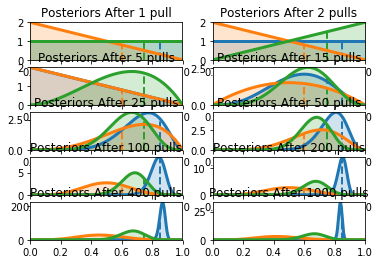

In [88]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = bayesian_strategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)

### regret

The best we can do is to always pick the bandit with the largest probability of winning. Denote this best bandit's probability by $w_{opt}$. Our score should be relative to how well we would have done had we chosen the best bandit from the beginning. This motivates the **total regret** of a strategy, defined:

$$\begin{align}
R_T = \sum_{i=1}^{T} \left( w_{opt} - w_{B(i)} \right) \\
Tw^* - \sum_{i=1}^{T} \;  w_{B(i)} 
\end{align}$$

where $w_{B(i)}$ is the probability of a prize of the chosen bandit in the $i$ round. A total regret of 0 means the strategy is matching the best possible score. This is likely not possible, as initially our algorithm will often make the wrong choice. Ideally, a strategy's total regret should flatten as it learns the best bandit. (Mathematically, we achieve $w_{B(i)}=w_{opt}$ often)

The **total regret of this simulation, including the scores of some other strategies**:

- strategy 1) **random_choice**: randomly choose a bandit to pull. If you can't beat this, just stop.
- strategy 2) **Largest Bayesian credible bounds**: pick the bandit with the largest upper bound in its 95% credible region of the underlying probability. See *lower_credible_choice* and *upper_credible_choice*
- strategy 3) **Bayes-UCB algorithm**: pick the bandit with the largest score, where score is a dynamic quantile of the posterior.
- strategy 4) **Mean of posterior**: choose the bandit with the largest posterior mean. This is what a human player would likely do.
- strategy 5) **Largest proportion**: pick the bandit with the current largest observed proportion of winning.

In [109]:
# strategy 1
def random_choice(self):
    return np.random.randint(0, len(self.wins))

# strategy 2
def lower_credible_choice( self ):
    """
    pick the bandit with the best lower bound
    """
    def lb(a,b):
        return a/(a + b) - 1.65 * np.sqrt((a*b)/((a + b)**2*(a + b + 1)))
    a = self.wins + 1
    b = self.trials - self.wins + 1
    return np.argmax(lb(a,b))
    
def upper_credible_choice(self):
    """
    pick the bandit with the best upper bound
    """
    def lb(a,b):
        return a/(a + b) + 1.65 * np.sqrt((a * b)/((a + b)**2*(a + b + 1)))
    a = self.wins + 1
    b = self.trials - self.wins + 1
    return np.argmax(lb(a,b))

# strategy 3
def ucb_bayes(self):
    """
    pick the bandit with the largest score, 
    where score is a dynamic quantile of the posterior
    """
    C = 0
    n = 10000
    alpha =1 - 1./((self.N+1))
    return np.argmax(beta.ppf(alpha, 1 + self.wins, 1 + self.trials - self.wins))

# strategy 4
def bayesian_bandit_choice(self):
    """
    Mean of posterior
    """
    return np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))


# stategy 5
def max_proportion(self):
    """
    pick the bandit with the current best observed proportion of winning
    """
    return np.argmax(self.wins / (self.trials +1))

In [110]:
class GeneralBanditStrat(object):

    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
        choice_function: accepts a self argument (which gives access to 
        all the variables), and returns and int between 0 and n-1
    methods:
        sample_bandits(n): sample and train on n pulls.
    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits, choice_function):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.score = []
        self.choice_function = choice_function

    def sample_bandits(self, n=1):
        
        score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = self.choice_function(self)
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            score[k] = result 
            self.N += 1
            choices[k] = choice
            
        self.score = np.r_[self.score, score]
        self.choices = np.r_[self.choices, choices]
        return 

In [99]:
#define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

#define regret
def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

#create new strategies
strategies= [upper_credible_choice, 
            bayesian_bandit_choice, 
            ucb_bayes , 
            max_proportion,
            random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

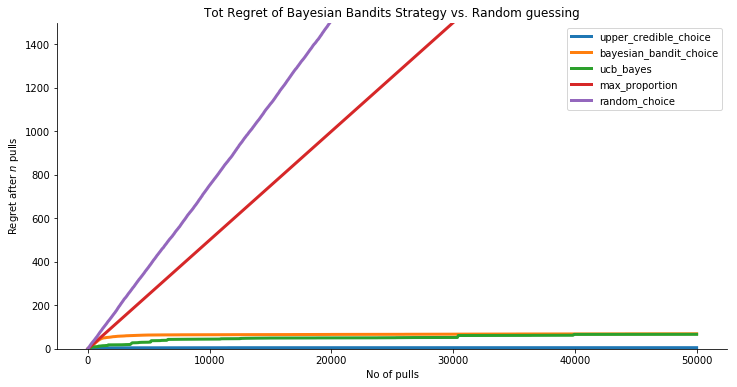

In [108]:
#train 10000 times
for strat in algos:
    strat.sample_bandits(10000)

fig, ax = plt.subplots(figsize=[12,6])
#test and plot
for i,strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    ax.plot(_regret, label = strategies[i].__name__, lw = 3)

_ = ax.set(title = 'Tot Regret of Bayesian Bandits Strategy vs. Random guessing', 
       xlabel = 'No of pulls', ylabel = 'Regret after $n$ pulls', ylim = [0,1500])
_ = ax.legend(loc = 'best')
remove_borders(ax)

### Extending the algorithm

Bayesian Bandits algorithm's are easy to extend. f.i.:

- If interested in the **minimum probability** (eg: where prizes are a bad thing), simply choose $B = \text{argmin} \; X_b$ and proceed.

- Adding **learning rates**: Suppose the underlying environment may change over time. Technically the standard Bayesian Bandit algorithm would self-update itself (awesome) by noting that what it thought was the best is starting to fail more often. We can motivate the algorithm to learn changing environments quicker by simply adding a rate term upon updating:

      self.wins[choice] = rate*self.wins[choice] + result
      self.trials[choice] = rate*self.trials[choice] + 1

If rate < 1, the algorithm will forget its previous wins quicker and there will be a downward pressure towards ignorance. Conversely, setting rate > 1 implies your algorithm will act more risky, and bet on earlier winners more often and be more resistant to changing environments.

- **Hierarchical algorithms**: We can setup a Bayesian Bandit algorithm on top of smaller bandit algorithms. Suppose we have $N$ Bayesian Bandit models, each varying in some behavior (for example different rate parameters, representing varying sensitivity to changing environments). On top of these $N$ models is another Bayesian Bandit learner that will select a sub-Bayesian Bandit. This chosen Bayesian Bandit will then make an internal choice as to which machine to pull. The super-Bayesian Bandit updates itself depending on whether the sub-Bayesian Bandit was correct or not.

- **Extending the rewards**, denoted $y_a$ for bandit $a$, to random variables from a distribution $f_{y_a}(y)$ is straightforward. More generally, this problem can be rephrased as "Find the bandit with the largest expected value", as playing the bandit with the largest expected value is optimal. In the case above, $f_{y_a}$ was Bernoulli with probability $p_a$, hence the expected value for a bandit is equal to $p_a$, which is why it looks like we are aiming to maximize the probability of winning. If $f$ is not Bernoulli, and it is non-negative, which can be accomplished apriori by shifting the distribution (we assume we know $f$), then the algorithm behaves as before:

For each round,

   - Sample a random variable $X_b$ from the prior of bandit $b$, for all $b$.
   - Select the bandit with largest sample, i.e. select bandit $B = \text{argmax}\;\; X_b$.
   - Observe the result,$R \sim f_{y_a}$, of pulling bandit $B$, and update your prior on bandit $B$.
   - Return to 1

The issue is in the sampling of $X_b$ drawing phase. With Beta priors and Bernoulli observations, we have a Beta posterior — this is easy to sample from. But now, with arbitrary distributions $f$, we have a non-trivial posterior. Sampling from these can be difficult.

- There has been some interest in **extending the Bayesian Bandit algorithm to commenting systems**. Recall in Chapter 4, we developed a ranking algorithm based on the Bayesian lower-bound of the proportion of upvotes to total votes. One problem with this approach is that it will bias the top rankings towards older comments, since older comments naturally have more votes (and hence the lower-bound is tighter to the true proportion). This creates a positive feedback cycle where older comments gain more votes, hence are displayed more often, hence gain more votes, etc. This pushes any new, potentially better comments, towards the bottom. J. Neufeld proposes a system to remedy this that uses a Bayesian Bandit solution.

His proposal is to consider each comment as a Bandit, with the number of pulls equal to the number of votes cast, and number of rewards as the number of upvotes, hence creating a $\text{Beta}(1+U,1+D)$ posterior. As visitors visit the page, samples are drawn from each bandit/comment, but instead of displaying the comment with the $\max$ sample, the comments are ranked according to the ranking of their respective samples. From J. Neufeld's blog [7]:

[The] resulting ranking algorithm is quite straightforward, each new time the comments page is loaded, the score for each comment is sampled from a $\text{Beta}(1+U,1+D)$, comments are then ranked by this score in descending order... This randomization has a unique benefit in that even untouched comments  $(U=1,D=0)$ have some chance of being seen even in threads with 5000+ comments (something that is not happening now), but, at the same time, the user is not likely to be inundated with rating these new comments.